In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

enable_code_paths = True

if enable_code_paths:
    URL_path = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/clean_dataset.csv"
    URL_path_save = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model"
    URL_helper ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/helper/"
else :
    URL_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
    URL_path_save = "/content/drive/MyDrive/turing_college_experiments/14_NLP/model"
    URL_helper = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
import sys
sys.path.append(URL_helper)

from colab_helper import proportion_balance_classes

Mounted at /content/drive


Now we will be installing all the modules that are required

In [ ]:
%%capture
!pip install torchinfo

We will be exploring the Bert model and see if we could find any good performance

In [ ]:
# Main Libraries
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchinfo import summary  # Model summary tool for PyTorch

# Transformers Library (for BERT and related utilities)
from transformers import BertTokenizer, BertModel, BertConfig

# Evaluation and Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# colorama
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)
theme_color

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [ ]:
dataframe = pd.read_csv(URL_path)
# dataframe["not_toxic"] = ((dataframe.iloc[:, 1:] == 0).all(axis=1)).astype(int)
dataframe.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


tensor([0.4357, 0.0435, 0.2409, 0.0137, 0.2262, 0.0400])
total samples 144790


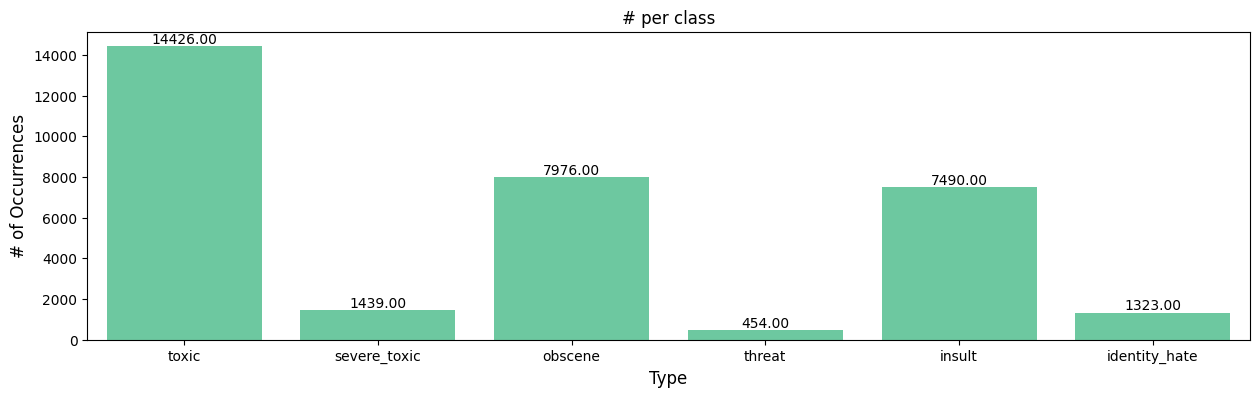

In [ ]:
target_y =dataframe.iloc[:,1:].sum()

weights_list = target_y.tolist()
weights = torch.tensor(weights_list, dtype=torch.float32)
normalized_weights = weights / weights.sum()
print(normalized_weights)

print(f"total samples {dataframe.shape[0]}")
proportion_balance_classes(target_y.index, target_y.values)

In this approach, we’ll use class weights without including all samples from the dataset, aiming to achieve better results by working with a subset of the data.

Now that we had a smaller dataset with all the data around the same balance, we will try to

In [ ]:
dataframe['list'] = dataframe[dataframe.columns[1:]].values.tolist()
dataframe_clean = dataframe[['comment_text', 'list']].copy()
dataframe_clean.head()

,comment_text,list
0,ExplanationWhy the edits made under my usernam...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""MoreI can't make any real suggestions on impr...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


# Dataset Parameters and model selection
- **MAX_LEN**: Maximum length of the tokenized sequences
- **TRAIN_BATCH_SIZE**: Batch size for the training set
- **VALID_BATCH_SIZE**: Batch size for the validation set


Then we select the BERT model

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class CustomDataset(Dataset):
    """Tokenize the dataset for using it in the model"""
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        values_return = {
                        'ids': torch.tensor(ids, dtype=torch.int64),
                        'mask': torch.tensor(mask, dtype=torch.int64),
                        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
                        'targets': torch.tensor(self.targets[index], dtype=torch.float)
                         }

        return values_return

# split and dataloader

We divided the dataset into 90% for training and 10% for validation in order to assess potential improvements in performance.


In [ ]:
# split
train_size = 0.9
train_dataset=dataframe_clean.sample(frac=train_size,random_state=42)
test_dataset=dataframe_clean.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe_clean.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# transforming the dataset
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

# dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

FULL Dataset: (144790, 2)
TRAIN Dataset: (130311, 2)
TEST Dataset: (14479, 2)


----------

# Fine tune the model

In [ ]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Linear(768, 256)
        self.l3 = torch.nn.Dropout(0.3)
        # because we are trying to predict 6 classes
        self.l4 = torch.nn.Linear(256, 6)

        # freeze the layers
        for param in self.l1.parameters():
            param.requires_grad = False
        for param in self.l1.encoder.layer[-1].parameters():
            param.requires_grad = True

        # name of the layers
        self.layer_names = {
            'bert_model': self.l1,
            'reducing_size': self.l2,
            'dropout': self.l3,
            'output_layer': self.l4,
        }

    def forward(self, ids, mask, token_type_ids):

        assert isinstance(ids, torch.Tensor), f"Expected tensor, got {type(ids)} for ids"
        assert isinstance(mask, torch.Tensor), f"Expected tensor, got {type(mask)} for mask"
        assert isinstance(token_type_ids, torch.Tensor), f"Expected tensor, got {type(token_type_ids)} for token_type_ids"

        output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_1 = output_1[1]
        output_2 = self.l2(output_1)
        output_3 = self.l3(output_2)
        output = self.l4(output_3)
        # print(output_3.shape)
        # print(output.shape)
        return output

model_bert = BertClass()
model_bert.to(device)

summary(model_bert)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Param #
BertClass                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Linear: 1-2                                           196,864
├─Dropout: 1-3                                          --
├─Li

We will be looking now the freezing layers to undestand which once the model need to be trainable

In [ ]:
def get_freeze_status_df(model):
    """ Returns a DataFrame indicating whether each layer is trainable or frozen. """
    freeze_status = []
    for name, param in model.named_parameters():
        freeze_status.append({
            'Layer Name': name,
            'Trainable': param.requires_grad
        })

    return pd.DataFrame(freeze_status)

# Call the function
freeze_status_df = get_freeze_status_df(model_bert)
freeze_status_df[freeze_status_df["Trainable"] == True ]

,Layer Name,Trainable
181,l1.encoder.layer.11.attention.self.query.weight,True
182,l1.encoder.layer.11.attention.self.query.bias,True
183,l1.encoder.layer.11.attention.self.key.weight,True
184,l1.encoder.layer.11.attention.self.key.bias,True
185,l1.encoder.layer.11.attention.self.value.weight,True
186,l1.encoder.layer.11.attention.self.value.bias,True
187,l1.encoder.layer.11.attention.output.dense.weight,True
188,l1.encoder.layer.11.attention.output.dense.bias,True
189,l1.encoder.layer.11.attention.output.LayerNorm...,True
190,l1.encoder.layer.11.attention.output.LayerNorm...,True


 # Parameters model

In this case, we selected 256 as the maximum token length because values above this threshold represent only about 5% of the data, making them statistically insignificant. Removing these outliers helps streamline training and improve efficiency. For this iteration, we will use training and validation batches of 8 and 4, with an initial learning rate set at 1e-04. The first model we will be testing is BERT.

In [ ]:
EPOCHS = 6
LEARNING_RATE = 1e-04
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# name of the model to save
model_name_to_save = "006_model_bert"

# train the model

In [ ]:
# Loss function
loss_fun_object = torch.nn.BCEWithLogitsLoss(pos_weight=normalized_weights)
def loss_fn(outputs, targets):
    return loss_fun_object(outputs, targets)

# Optimizer
param_groups = [
    {'params': model_bert.l1.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model_bert.l3.parameters(), 'lr': LEARNING_RATE},
]

# Create the optimizer using AdamW with parameter groups
optimizer = torch.optim.AdamW(param_groups, weight_decay=0.001)

# Store loss, accuracy, and recall
def calculate_accuracy(outputs, targets):
    preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = preds.round()  # Round to get binary predictions
    return (preds == targets).float().mean()  # Calculate accuracy

def calculate_recall(outputs, targets):
    preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = preds.round()  # Round to get binary predictions
    true_positives = (preds * targets).sum()  # TP
    false_negatives = ((1 - preds) * targets).sum()  # FN
    recall = true_positives / (true_positives + false_negatives + 1e-10)  # Add epsilon to avoid division by zero
    return recall.item()

# Initialize history lists
loss_history = []
accuracy_history = []
recall_history = []

# Training function
def train(epoch, model, dataset_loader, device):
    """ Train the model """
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_recall = 0.0
    total_samples = 0

    # Iterate through the batches
    for _, data in tqdm(enumerate(dataset_loader, 0), total=len(dataset_loader)):
        ids = data['ids'].to(device, dtype=torch.int64)
        mask = data['mask'].to(device, dtype=torch.int8)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.int64)
        targets = data['targets'].to(device, dtype=torch.float32)  # Use float for BCEWithLogitsLoss

        # Forward pass
        outputs = model(ids, mask, token_type_ids)

        # Compute loss and backpropagate
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item() * ids.size(0)  # Scale by batch size
        running_accuracy += calculate_accuracy(outputs, targets).item() * ids.size(0)
        running_recall += calculate_recall(outputs, targets) * ids.size(0)
        total_samples += ids.size(0)

    # Compute epoch-level metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_accuracy / total_samples
    epoch_recall = running_recall / total_samples  # Compute average recall over the epoch
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    recall_history.append(epoch_recall)

    print(f"Epoch {epoch} - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Training Recall: {epoch_recall:.4f}")
    return model, loss_history, accuracy_history, recall_history

We will use fewer epochs than in previous experiments, but we will monitor their performance closely.

# Validation set

In [ ]:
loss_values = []
accuracy_values = []
recall_values = []  # Initialize a list to store recall values

def validation(epoch, model, dataloader, device, loss_fun, threshold_target=0.5):
    model.eval()  # Set model to evaluation mode
    fin_targets = []
    fin_outputs = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fun(outputs, targets)  # Calculate loss
            total_loss += loss.item() * ids.size(0)
            total_samples += ids.size(0)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    # Calculate average loss over the entire validation set
    avg_loss = total_loss / total_samples
    fin_outputs = (np.array(fin_outputs) > threshold_target).astype(int)
    fin_targets = np.array(fin_targets)

    accuracy = accuracy_score(fin_targets, fin_outputs)
    recall = recall_score(fin_targets, fin_outputs, average='macro')

    loss_values.append(avg_loss)
    accuracy_values.append(accuracy)
    recall_values.append(recall)  # Append recall to the list

    print(f"Epoch {epoch} - Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Validation Recall: {recall:.4f}")
    return fin_outputs, fin_targets, loss_values, accuracy_values, recall_values


# Epochs
We will run multiple iterations and observe how the model responds as training progresses.

In [ ]:
for epoch in range(EPOCHS):

    print("===Training===")
    start_time = time.time()
    print(f'The training_loader: {len(training_loader)}')

    # Entrenamiento del modelo
    model_bert, loss_history_train, accuracy_history_train, recall_history_train = train(epoch, model_bert, training_loader, device)

    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')
    print("Loss History:", loss_history_train)
    print("Accuracy History:", accuracy_history_train)
    print("Recall History:", recall_history_train)  # Mostrar historial de recall

    print("===Testing===")
    print(f'The testing_loader: {len(testing_loader)}')

    # Validación del modelo
    outputs, targets, loss_history_valid, accuracy_history_valid, recall_history_valid = validation(epoch, model_bert, testing_loader, device, loss_fun_object)

    print("Loss History:", loss_history_valid)
    print("Accuracy History:", accuracy_history_valid)
    print("Recall History:", recall_history_valid)  # Mostrar historial de recall

    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')


===Training===
The training_loader: 16289


100%|██████████| 16289/16289 [1:20:07<00:00,  3.39it/s]


Epoch 0 - Training Loss: 0.3444, Training Accuracy: 0.9713, Training Recall: 0.1309
Epoch 1/6 completed in 4807.30 seconds.
Loss History: [0.3444423455469082]
Accuracy History: [0.971318616273521]
Recall History: [0.1308534226160042]
===Testing===
The testing_loader: 3620


100%|██████████| 3620/3620 [08:09<00:00,  7.39it/s]


Epoch 0 - Validation Loss: 0.3078, Validation Accuracy: 0.9054, Validation Recall: 0.1928
Loss History: [0.3078069994401698]
Accuracy History: [0.9054492713585193]
Recall History: [0.19278508309985057]
Epoch 1/6 completed in 5297.26 seconds.
===Training===
The training_loader: 16289


  0%|          | 0/16289 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 16289/16289 [1:19:17<00:00,  3.42it/s]


Epoch 1 - Training Loss: 0.2951, Training Accuracy: 0.9755, Training Recall: 0.1932
Epoch 2/6 completed in 4757.07 seconds.
Loss History: [0.3444423455469082, 0.29509493440412277]
Accuracy History: [0.971318616273521, 0.9754625490809876]
Recall History: [0.1308534226160042, 0.19322186106004802]
===Testing===
The testing_loader: 3620


100%|██████████| 3620/3620 [08:07<00:00,  7.43it/s]


Epoch 1 - Validation Loss: 0.2678, Validation Accuracy: 0.9080, Validation Recall: 0.2208
Loss History: [0.3078069994401698, 0.2677807198167547]
Accuracy History: [0.9054492713585193, 0.9080046964569376]
Recall History: [0.19278508309985057, 0.2208453515697211]
Epoch 2/6 completed in 5244.61 seconds.
===Training===
The training_loader: 16289


  0%|          | 0/16289 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 16289/16289 [1:19:44<00:00,  3.40it/s]


Epoch 2 - Training Loss: 0.2601, Training Accuracy: 0.9764, Training Recall: 0.2121
Epoch 3/6 completed in 4784.26 seconds.
Loss History: [0.3444423455469082, 0.29509493440412277, 0.26007393423320846]
Accuracy History: [0.971318616273521, 0.9754625490809876, 0.9764038868615357]
Recall History: [0.1308534226160042, 0.19322186106004802, 0.21210659594513542]
===Testing===
The testing_loader: 3620


100%|██████████| 3620/3620 [08:07<00:00,  7.43it/s]


Epoch 2 - Validation Loss: 0.2385, Validation Accuracy: 0.9090, Validation Recall: 0.2236
Loss History: [0.3078069994401698, 0.2677807198167547, 0.23847917151558967]
Accuracy History: [0.9054492713585193, 0.9080046964569376, 0.9090406796049451]
Recall History: [0.19278508309985057, 0.2208453515697211, 0.22359357135944932]
Epoch 3/6 completed in 5271.86 seconds.
===Training===
The training_loader: 16289


  0%|          | 0/16289 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 16289/16289 [1:20:23<00:00,  3.38it/s]


Epoch 3 - Training Loss: 0.2337, Training Accuracy: 0.9772, Training Recall: 0.2213
Epoch 4/6 completed in 4823.85 seconds.
Loss History: [0.3444423455469082, 0.29509493440412277, 0.26007393423320846, 0.2336779730794496]
Accuracy History: [0.971318616273521, 0.9754625490809876, 0.9764038868615357, 0.9771968616692496]
Recall History: [0.1308534226160042, 0.19322186106004802, 0.21210659594513542, 0.22134126760010953]
===Testing===
The testing_loader: 3620


100%|██████████| 3620/3620 [08:07<00:00,  7.42it/s]


Epoch 3 - Validation Loss: 0.2156, Validation Accuracy: 0.9127, Validation Recall: 0.2599
Loss History: [0.3078069994401698, 0.2677807198167547, 0.23847917151558967, 0.21562495945616234]
Accuracy History: [0.9054492713585193, 0.9080046964569376, 0.9090406796049451, 0.9127011533945715]
Recall History: [0.19278508309985057, 0.2208453515697211, 0.22359357135944932, 0.25988388905106263]
Epoch 4/6 completed in 5311.69 seconds.
===Training===
The training_loader: 16289


  0%|          | 0/16289 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 16289/16289 [1:19:40<00:00,  3.41it/s]


Epoch 4 - Training Loss: 0.2131, Training Accuracy: 0.9780, Training Recall: 0.2319
Epoch 5/6 completed in 4780.01 seconds.
Loss History: [0.3444423455469082, 0.29509493440412277, 0.26007393423320846, 0.2336779730794496, 0.21313795942625538]
Accuracy History: [0.971318616273521, 0.9754625490809876, 0.9764038868615357, 0.9771968616692496, 0.9779565826627511]
Recall History: [0.1308534226160042, 0.19322186106004802, 0.21210659594513542, 0.22134126760010953, 0.2318692647381]
===Testing===
The testing_loader: 3620


100%|██████████| 3620/3620 [08:02<00:00,  7.50it/s]


Epoch 4 - Validation Loss: 0.1979, Validation Accuracy: 0.9113, Validation Recall: 0.2542
Loss History: [0.3078069994401698, 0.2677807198167547, 0.23847917151558967, 0.21562495945616234, 0.1978983033678217]
Accuracy History: [0.9054492713585193, 0.9080046964569376, 0.9090406796049451, 0.9127011533945715, 0.911250776987361]
Recall History: [0.19278508309985057, 0.2208453515697211, 0.22359357135944932, 0.25988388905106263, 0.2541731985491745]
Epoch 5/6 completed in 5263.02 seconds.
===Training===
The training_loader: 16289


  0%|          | 0/16289 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 16289/16289 [1:20:13<00:00,  3.38it/s]


Epoch 5 - Training Loss: 0.1968, Training Accuracy: 0.9785, Training Recall: 0.2410
Epoch 6/6 completed in 4813.11 seconds.
Loss History: [0.3444423455469082, 0.29509493440412277, 0.26007393423320846, 0.2336779730794496, 0.21313795942625538, 0.19676721458473537]
Accuracy History: [0.971318616273521, 0.9754625490809876, 0.9764038868615357, 0.9771968616692496, 0.9779565826627511, 0.978463063440961]
Recall History: [0.1308534226160042, 0.19322186106004802, 0.21210659594513542, 0.22134126760010953, 0.2318692647381, 0.2410178716432396]
===Testing===
The testing_loader: 3620


100%|██████████| 3620/3620 [08:01<00:00,  7.51it/s]

Epoch 5 - Validation Loss: 0.1835, Validation Accuracy: 0.9117, Validation Recall: 0.2474
Loss History: [0.3078069994401698, 0.2677807198167547, 0.23847917151558967, 0.21562495945616234, 0.1978983033678217, 0.18353783403018273]
Accuracy History: [0.9054492713585193, 0.9080046964569376, 0.9090406796049451, 0.9127011533945715, 0.911250776987361, 0.911665170246564]
Recall History: [0.19278508309985057, 0.2208453515697211, 0.22359357135944932, 0.25988388905106263, 0.2541731985491745, 0.24742332925348753]
Epoch 6/6 completed in 5294.99 seconds.


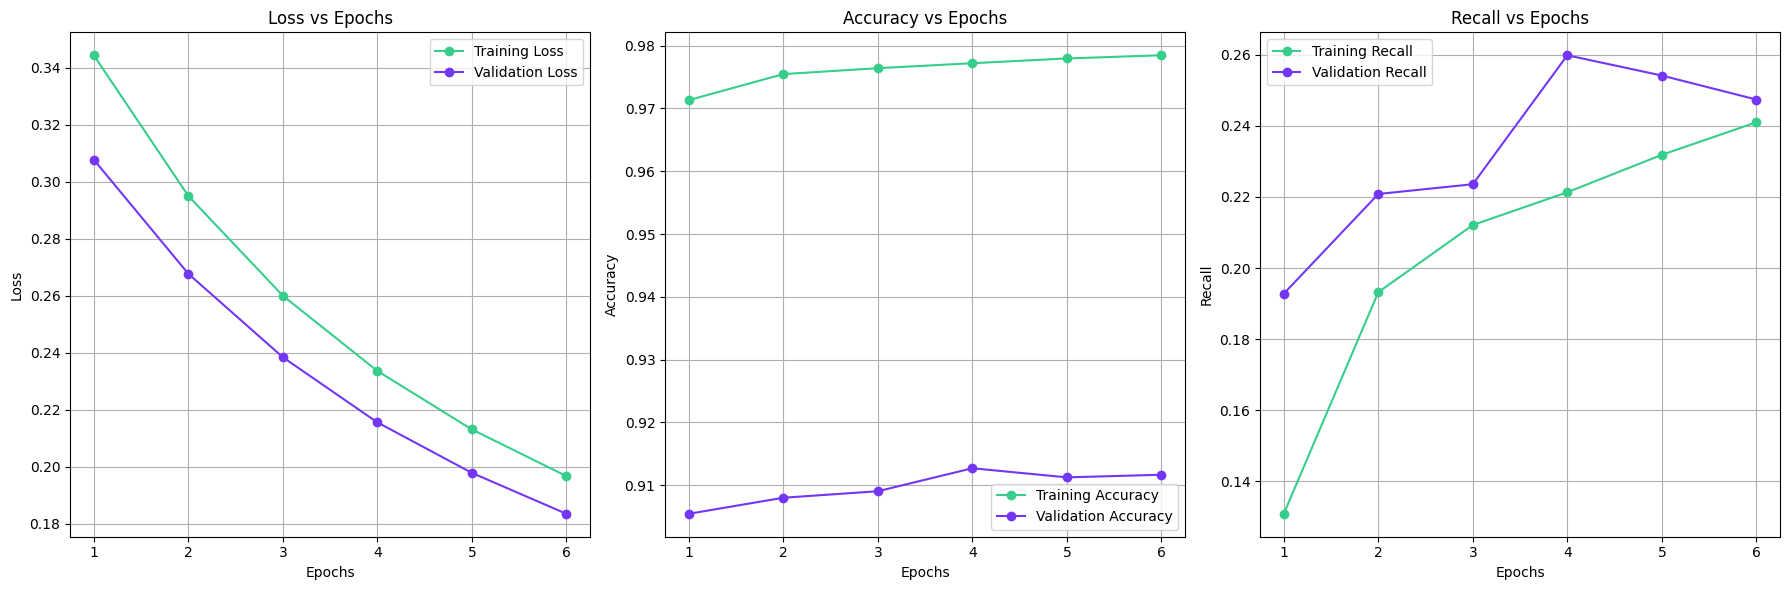

In [ ]:
epochs = range(1, len(loss_history_train) + 1)

plt.figure(figsize=(18, 6))  # Aumentar el tamaño de la figura para tres subgráficas

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_history_train, label="Training Loss", marker='o')
plt.plot(epochs, loss_history_valid, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy_history_train, label="Training Accuracy", marker='o')
plt.plot(epochs, accuracy_history_valid, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(1, 3, 3)
plt.plot(epochs, recall_history_train, label="Training Recall", marker='o')
plt.plot(epochs, recall_history_valid, label="Validation Recall", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall vs Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

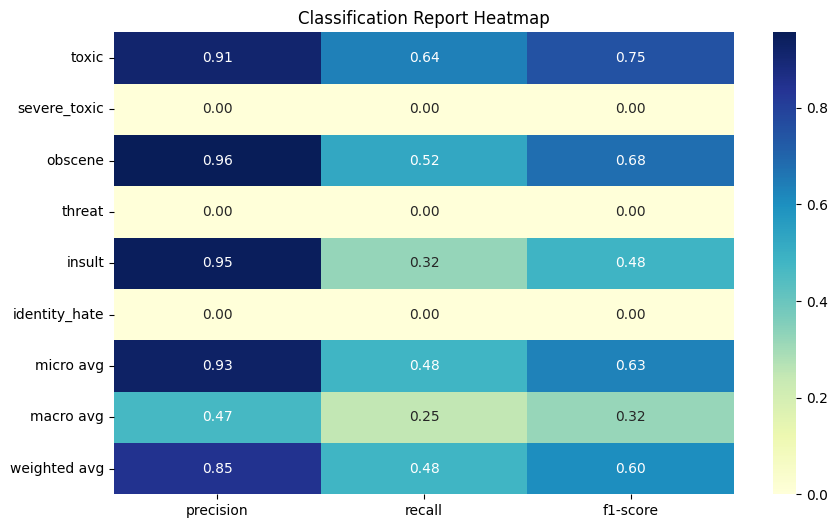

In [ ]:
report = metrics.classification_report(targets, outputs, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

#   outputs, targets,
class_names = dataframe.iloc[:,1:-1].columns.tolist()

for i in range(len(class_names)):
    report_df.rename(index={str(i): class_names[i]}, inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


We could see from this values that they are not predicting any value correcly to some classes so we need  to figure it out to solve it.

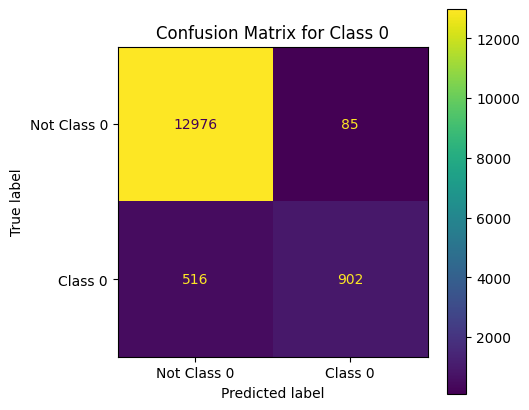

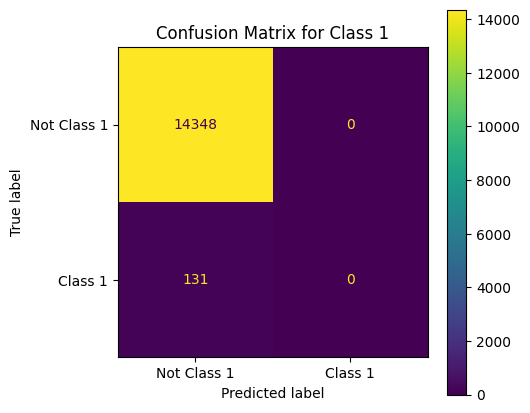

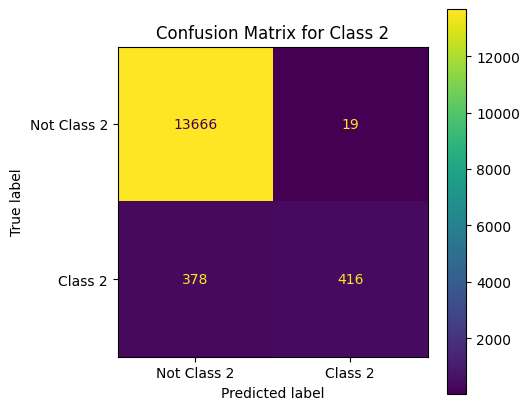

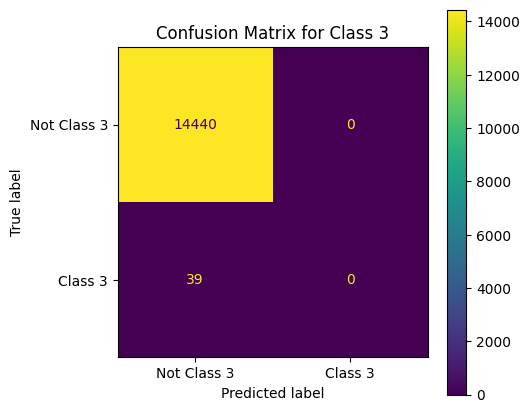

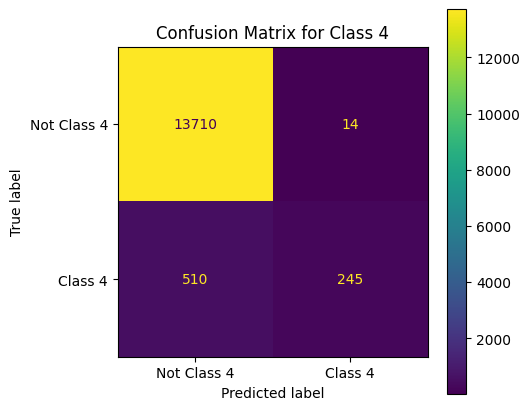

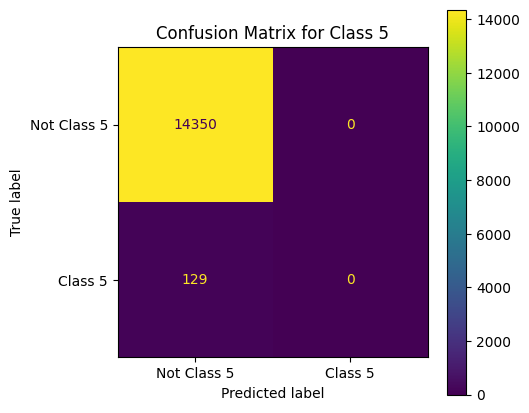

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrices for each class
conf_matrices = multilabel_confusion_matrix(targets, outputs)

# Plot each confusion matrix
for i, conf_matrix in enumerate(conf_matrices):
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=[f"Not Class {i}", f"Class {i}"])
    fig, ax = plt.subplots(figsize=(5, 5))
    display.plot(ax=ax)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.show()

The model performs well for certain classes like toxic and insult, with relatively higher precision and recall, but struggles with others, notably identity_hate and severe_toxic, where it achieves low or even zero scores. This suggests the model has difficulty identifying nuances in some categories, potentially due to class imbalance or insufficient feature learning.

# Export the model
We will be exporting the model

In [ ]:
torch.save(model_bert, f'{URL_path_save}/{model_name_to_save}.pth')
tokenizer.save_pretrained(f'{URL_path_save}/{model_name_to_save}_token.pth')

('/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/006_model_bert_token.pth/tokenizer_config.json',
 '/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/006_model_bert_token.pth/special_tokens_map.json',
 '/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/006_model_bert_token.pth/vocab.txt',
 '/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/006_model_bert_token.pth/added_tokens.json')

# Load the model

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the model's state dictionary
# model_state_dict = torch.load(f'{URL_path_save}/{model_name_to_save}.pth')
model_state_dict = torch.load(f'{URL_path_save}/{model_name_to_save}.pth', map_location=torch.device('cpu'))
model_bert_load = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path='bert-base-uncased', num_labels=6)
tokenizer_load = BertTokenizer.from_pretrained(f'{URL_path_save}/{model_name_to_save}_token.pth')

<ipython-input-25-0152830192e0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(f'{URL_path_save}/{model_name_to_save}.pth', map_location=torc

# Example prediction
We will plot an example of a prediction to see how it performs

In [ ]:
# extract the data
sample_1 = dataframe[dataframe["toxic"] == 1]
sample_2 = dataframe[dataframe["toxic"] == 0]

precition_value_1 = sample_1.iloc[0,1:-1]
precition_value_2 = sample_2.iloc[0,1:-1]

sample_1 = sample_1.iloc[0,0]
sample_2 = sample_2.iloc[0,0]

def prediction_function_single_text(sample, model,tokenizer, precition_value):
    inputs = tokenizer(sample, return_tensors='pt', padding=True, truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1)

    # Display the result
    print(f"Input Text: {sample}")
    print(f"Predicted Class: {predicted_class.item()}")
    print(f"Real_values: \n {precition_value} ")


In [ ]:
model_bert_load.eval()
prediction_function_single_text(sample_1, model_bert_load, tokenizer_load, precition_value_1)

Input Text: COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Predicted Class: 2
Real_values: 
 toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: object 


In [ ]:
prediction_function_single_text(sample_2, model_bert_load, tokenizer_load, precition_value_2)

Input Text: ExplanationWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Predicted Class: 5
Real_values: 
 toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: object 


preddict one sample but the other one its not predicting the text correctly so its better then the past model.

# Summary

In the next experiment, we may try adding more samples to the categories where predictions are currently underperforming. To improve model performance, we plan to experiment with:

* Adjusting the threshold to see if modifications can enhance accuracy.
* Adding more samples through backtranslation to further boost the model's performance.